--- 阶段 0: 数据准备 ---
filename is NO_Fuse_CheKu.csv

Data loaded successfully!
Training data shape:   (2688, 24)
Validation data shape: (2399, 24)
Testing data shape:    (2664, 24)

Identified 6 WiFi features and 6 IMU features.
数据已在DataFrame上完成标准化。
正在从DataFrame创建异构图数据列表 (消融试验：无融合边)...


c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


数据加载器创建完毕。

--- 阶段 1: 模型实例化 ---
端到端模型实例化完成。

--- 开始第一阶段：基础模型训练 (学习核心预测能力) ---


Phase 1 Epochs:   5%|▌         | 26/500 [00:21<06:23,  1.24it/s, LR=0.000300, TrainLoss=0.3360, ValLoss=0.4135]



第一阶段早停于 Epoch 27
--- 第一阶段训练完成 ---
最佳基础模型已保存至: Model/phase1_best_model_NO_FUSES.pth

--- 开始第二阶段：物理精调 (学习平滑性与一致性) ---
正在加载第一阶段的最佳模型: Model/phase1_best_model_NO_FUSES.pth


Phase 2 Epochs:  15%|█▌        | 15/100 [00:12<01:09,  1.23it/s, LR=0.000003, TrainLoss=0.3614, ValLoss=0.4098]



第二阶段早停于 Epoch 16
--- 第二阶段精调完成 ---
最佳精调模型已保存至: Model/phase2_finetuned_best_model_NO_FUSES.pth

--- 最终测试: 加载精调后的最佳模型 ---


Testing: 100%|██████████| 21/21 [00:00<00:00, 69.09it/s]


Test Loss: 0.3615
Test results saved to 'results/Gkan_NO_FUSES_NO_Fuse_CheKu.csv'

--- 模型评估结果 (消融试验: 无融合边) ---
X轴均方误差 (MSE X): 40.5634 (米^2)
Y轴均方误差 (MSE Y): 699.9680 (米^2)
总均方根误差 (RMSE): 19.2423 (米)
平均位移误差 (ADE/FDE): 23.0723 (米)
--------------------


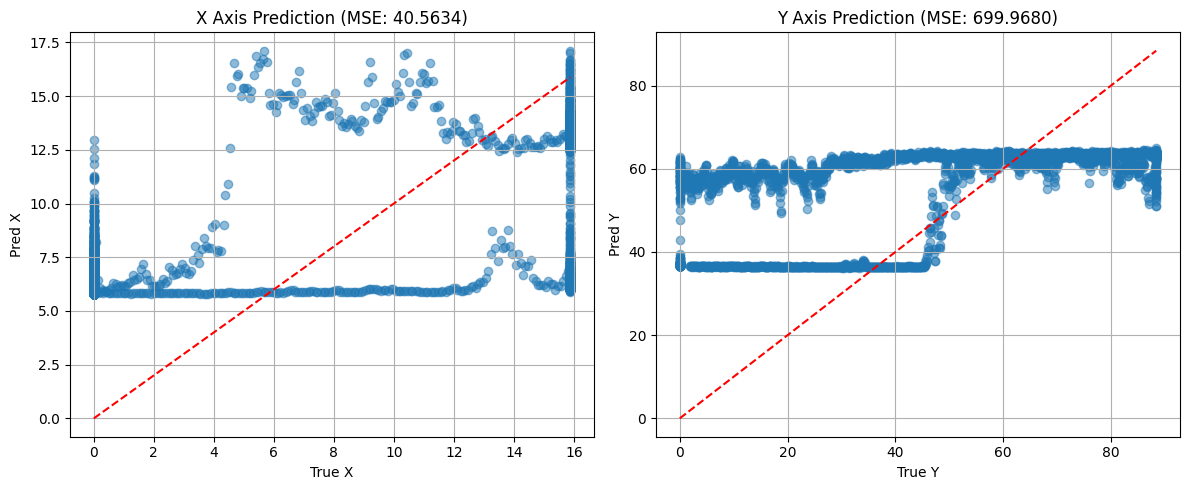

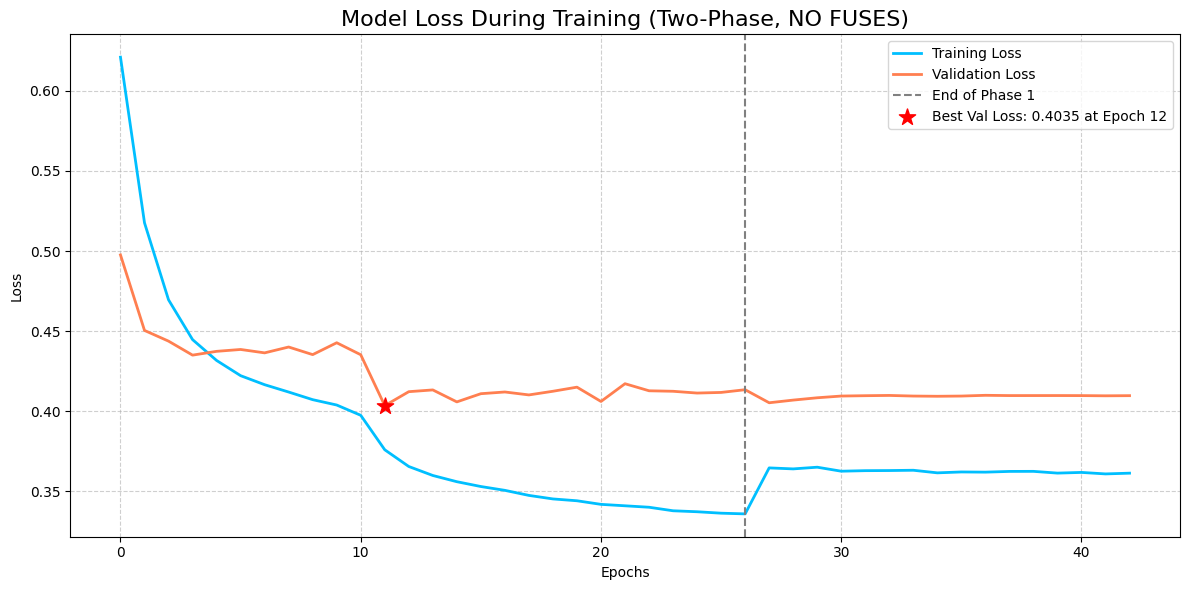

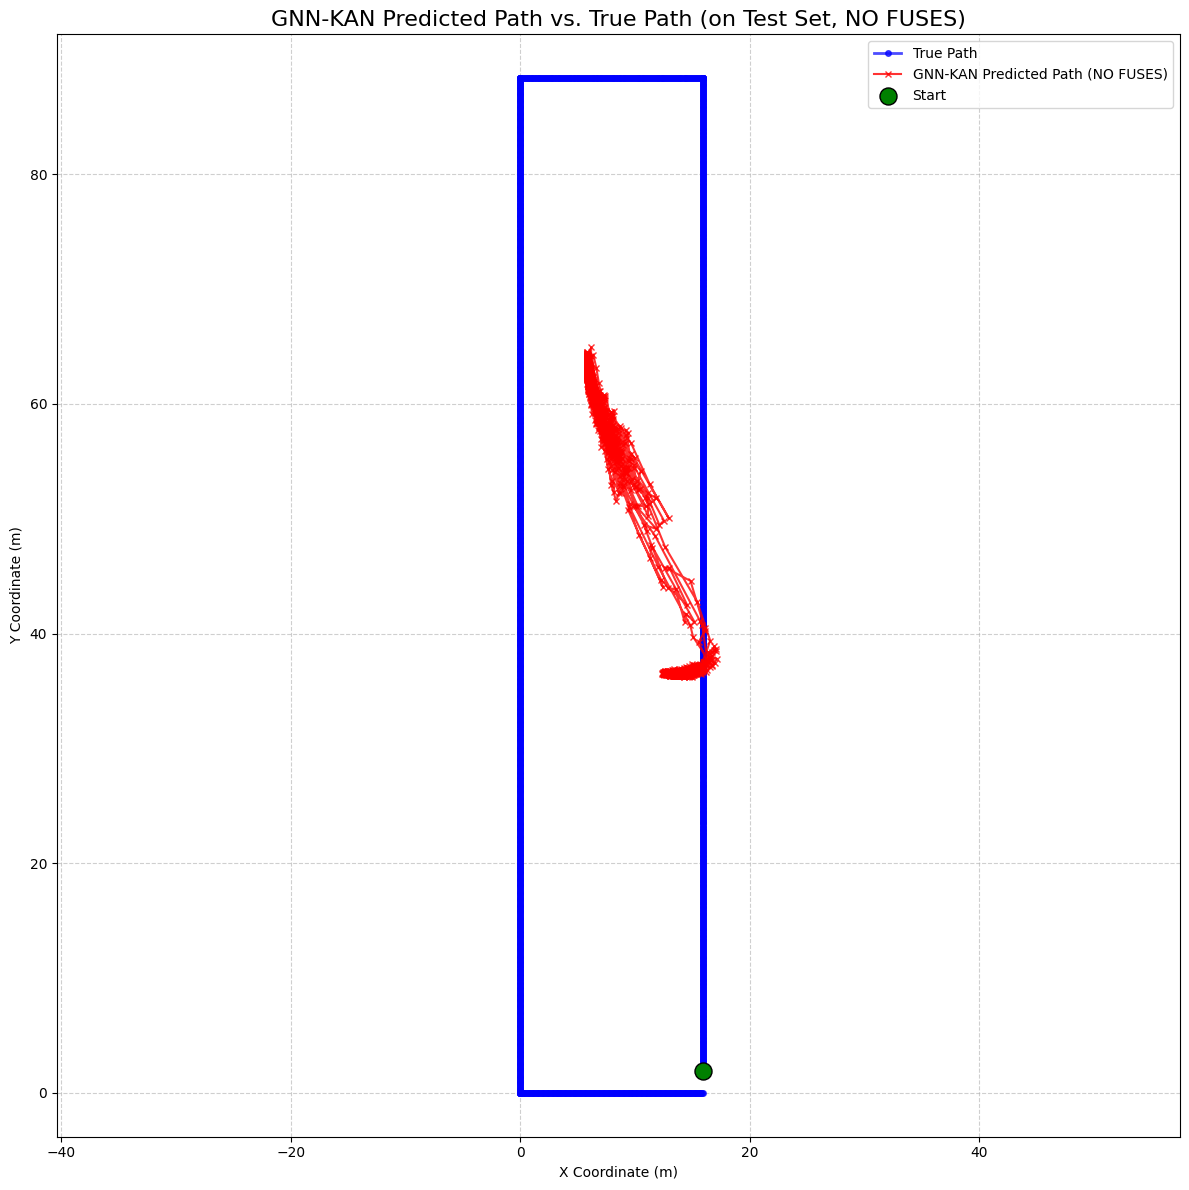

In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from kan_improved import KAN
from utils import create_graph_list_from_df_NO_FUSES, create_temporal_edges_with_attr, GNNEncoder, GNN_LSTKAN_with_Attention_v2
import torch.nn.functional as F



# 1. 获取当前 Notebook/脚本的运行目录
#    (例如: 'd:\科研\科研\去掉聚合边')
current_dir = os.getcwd() 

# 2. 获取上一级目录 (即 'loss_function' 所在的目录)
#    (例如: 'd:\科研\科研')
parent_dir = os.path.dirname(current_dir)

# 3. 将上一级目录添加到 Python 的搜索路径中
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from loss_function.custom_lossess_v4 import jerk_smoothness_loss_v2, velocity_heading_consistency_loss_v2



print("--- 阶段 0: 数据准备 ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
direct = "../Datasets/"
filesname = "NO_Fuse_CheKu.csv"
print(f"filename is {filesname}")
# data = pd.read_csv(direct + filesname)
# # 2. 定义分割比例
# train_ratio = 0.8
# val_ratio = 0.1
# # # 剩下的 10% 将作为测试集

# # # 3. 计算分割点索引 (按时间顺序)
# data_size = len(data)
# train_end_idx = int(train_ratio * data_size)
# val_end_idx = train_end_idx + int(val_ratio * data_size)

# # # # 4. 使用 .iloc 分割 DataFrame
# train_data = data.iloc[:train_end_idx]
# val_data = data.iloc[train_end_idx:val_end_idx]
# test_data = data.iloc[val_end_idx:]

train_data = pd.read_csv(r'../Datasets/x_train.csv')
val_data = pd.read_csv(r'../Datasets/x_val.csv')
test_data = pd.read_csv(r'../Datasets/x_test.csv')

print("\nData loaded successfully!")
print(f"Training data shape:   {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape:    {test_data.shape}")

column_names = train_data.drop(['timestamp','x_coord', 'y_coord'], axis=1).columns.tolist()
coord_cols = ['x_coord', 'y_coord']
wifi_features = [col for col in column_names if any(sensor in col for sensor in ["rot", "RSSI"])] 
imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope"])] 
print(f"\nIdentified {len(wifi_features)} WiFi features and {len(imu_features)} IMU features.")

scaler_wifi = StandardScaler().fit(train_data[wifi_features])
scaler_imu = StandardScaler().fit(train_data[imu_features])
scaler_coords = StandardScaler().fit(train_data[coord_cols])

train_df_scaled = train_data.copy()
val_df_scaled = val_data.copy()
test_df_scaled = test_data.copy()

for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
    df[wifi_features] = scaler_wifi.transform(df[wifi_features])
    df[imu_features] = scaler_imu.transform(df[imu_features])
    df[coord_cols] = scaler_coords.transform(df[coord_cols])
print("数据已在DataFrame上完成标准化。")

windows_size = 20
future_steps = 3

# 【核心修改】
# 移除了 future_radius 和 past_radius，因为新函数用不到它们
# future_radius = 10
# past_radius = 15 

print("正在从DataFrame创建异构图数据列表 (消融试验：无融合边)...")
# 【核心修改】调用新的图创建函数
train_data_list = create_graph_list_from_df_NO_FUSES(train_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu')
val_data_list = create_graph_list_from_df_NO_FUSES(val_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu')
test_data_list = create_graph_list_from_df_NO_FUSES(test_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu')


batch_size = 128
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)
print("数据加载器创建完毕。")

# ==============================================================================
#                    第二部分: 模型实例化 (使用原始 KAN)
# ==============================================================================
print("\n--- 阶段 1: 模型实例化 ---")
wifi_feat_dim = len(wifi_features)
imu_feat_dim = len(imu_features)
gnn_hidden_dim = 32 
kan_output_dim = future_steps * 2
gnn_heads = 4
kan_dropout = 0.2

# 【保留】使用您原始的 GNNEncoder
gnn_encoder_instance = GNNEncoder(
    wifi_input_dim=wifi_feat_dim,
    imu_input_dim=imu_feat_dim,
    hidden_dim=gnn_hidden_dim,
    windows_size=windows_size,
    num_layers=1,
    heads=gnn_heads,
    dropout=kan_dropout
).to(device)

# 【保留】使用您原始的 KAN
kan_layers_config = [gnn_hidden_dim, 64, kan_output_dim]
kan_predictor_instance = KAN(
    layers_hidden=kan_layers_config,
    use_lstm=True,
    lstm_hidden=32, 
    dropout_rate=kan_dropout,
    grid_size=5,
    spline_order=3,
).to(device)

# 【保留】使用您原始的包装器
end_to_end_model = GNN_LSTKAN_with_Attention_v2(
    gnn_encoder=gnn_encoder_instance,
    kan_predictor=kan_predictor_instance,
    future_steps=future_steps
).to(device)
print("端到端模型实例化完成。")

# ==============================================================================
#                    第三部分：两阶段训练函数定义
# ==============================================================================

def train_phase_1(model, train_loader, val_loader, initial_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, model_save_path):
    """
    【保留】执行第一阶段的训练：使用基础损失 + KAN正则化。
    """
    print("\n" + "="*80)
    print("--- 开始第一阶段：基础模型训练 (学习核心预测能力) ---")
    print("="*80)
    
    device = next(model.parameters()).device
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    best_val_loss = float('inf')
    patience_counter = 0
    
    # 用于绘图
    train_losses, val_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 1 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            # 【新增】速度损失
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            # 【保留】KAN 正则化
            reg_loss = model.regularization_loss()
            total_loss = base_loss + kan_reg_weight * reg_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
                
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                # 【保留】验证损失不包含正则化项
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(TrainLoss=f'{avg_train_loss:.4f}', ValLoss=f'{avg_val_loss:.4f}', LR=f'{optimizer.param_groups[0]["lr"]:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n第一阶段早停于 Epoch {epoch + 1}")
            break
            
    print(f"--- 第一阶段训练完成 ---")
    print(f"最佳基础模型已保存至: {model_save_path}")
    return train_losses, val_losses

def train_phase_2_finetune(pretrained_model_path, model, train_loader, val_loader, finetune_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, smooth_weight, consistency_weight, finetuned_model_save_path):
    """
    【保留】执行第二阶段的训练：加载预训练模型，并用包含物理正则项的损失进行精调。
    """
    print("\n" + "="*80)
    print("--- 开始第二阶段：物理精调 (学习平滑性与一致性) ---")
    print("="*80)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"正在加载第一阶段的最佳模型: {pretrained_model_path}")
    model.load_state_dict(torch.load(pretrained_model_path, weights_only=False))

    model.to(device)

    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    patience_counter = 0
    
    # 用于绘图
    train_losses, val_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 2 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            # 【保留】物理正则化
            smooth_loss = jerk_smoothness_loss_v2(main_pred)
            consistency_loss = velocity_heading_consistency_loss_v2(main_pred)
            # reg_loss = model.regularization_loss()

            # 【保留】总损失包含物理正则化
            total_loss = (base_loss + smooth_weight * smooth_loss + consistency_weight * consistency_loss) #kan_reg_weight * reg_loss)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                # 【保留】验证损失不包含正则化项
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(TrainLoss=f'{avg_train_loss:.4f}', ValLoss=f'{avg_val_loss:.4f}', LR=f'{optimizer.param_groups[0]["lr"]:.6f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), finetuned_model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\n第二阶段早停于 Epoch {epoch + 1}")
            break

    print(f"--- 第二阶段精调完成 ---")
    print(f"最佳精调模型已保存至: {finetuned_model_save_path}")
    return train_losses, val_losses

# ==============================================================================
#                      第四部分: 主执行流程
# ==============================================================================
if __name__ == "__main__":
    
    # --- 【保留】定义所有原始超参数 ---
    os.makedirs('Model', exist_ok=True)
    
    PHASE_1_LR = 3e-4
    PHASE_1_EPOCHS = 500
    PHASE_1_PATIENCE = 15
    
    PHASE_2_LR = 1e-5 
    PHASE_2_EPOCHS = 100
    PHASE_2_PATIENCE = 15
    
    WEIGHT_DECAY = 2e-4
    KAN_REG_WEIGHT = 2e-4
    LAMBDA_VEL = 0.3
    SMOOTH_WEIGHT = 1e-4
    CONSISTENCY_WEIGHT = 2e-4

    # --- 执行第一阶段训练 ---
    # (建议修改模型名称以作区分)
    phase1_model_path = 'Model/phase1_best_model_NO_FUSES.pth'
    p1_train_losses, p1_val_losses = train_phase_1(
        model=end_to_end_model,
        train_loader=train_loader,
        val_loader=val_loader,
        initial_lr=PHASE_1_LR,
        weight_decay=WEIGHT_DECAY,
        num_epochs=PHASE_1_EPOCHS,
        patience=PHASE_1_PATIENCE,
        kan_reg_weight=KAN_REG_WEIGHT,
        lambda_vel=LAMBDA_VEL,
        model_save_path=phase1_model_path
    )
    
    # --- 执行第二阶段精调 ---
    # (建议修改模型名称以作区分)
    phase2_model_path = 'Model/phase2_finetuned_best_model_NO_FUSES.pth'
    p2_train_losses, p2_val_losses = train_phase_2_finetune(
        pretrained_model_path=phase1_model_path,
        model=end_to_end_model,
        train_loader=train_loader,
        val_loader=val_loader,
        finetune_lr=PHASE_2_LR,
        weight_decay=WEIGHT_DECAY,
        num_epochs=PHASE_2_EPOCHS,
        patience=PHASE_2_PATIENCE,
        kan_reg_weight=KAN_REG_WEIGHT,
        lambda_vel=LAMBDA_VEL,
        smooth_weight=SMOOTH_WEIGHT,
        consistency_weight=CONSISTENCY_WEIGHT,
        finetuned_model_save_path=phase2_model_path
    )
    
    # 合并两个阶段的损失用于绘图
    train_losses = p1_train_losses + p2_train_losses
    val_losses = p1_val_losses + p2_val_losses

    # =================================================================
    #                     第五部分: 测试与评估
    # =================================================================
    print("\n--- 最终测试: 加载精调后的最佳模型 ---")
    end_to_end_model.load_state_dict(torch.load(phase2_model_path, weights_only=False))
    
    end_to_end_model.eval()
    test_loss = 0
    pred_coords_list = []
    true_coords_list = []
    criterion = nn.HuberLoss()

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            batch = batch.to(device)
            pred_seq,_,_ = end_to_end_model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            # 【注意】测试损失也不应包含正则项
            loss_coord_test = criterion(pred_seq, true_seq)
            pred_vel_test = (pred_seq[:, 1:] - pred_seq[:, :-1])
            true_vel_test = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel_test = criterion(pred_vel_test, true_vel_test)
            loss = loss_coord_test + LAMBDA_VEL * loss_vel_test

            test_loss += loss.item()
            pred_last_step = pred_seq[:, -1, :].cpu().numpy()
            true_last_step = true_seq[:, -1, :].cpu().numpy()
            pred_coords_list.append(pred_last_step)
            true_coords_list.append(true_last_step)

    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

    pred_coords = np.concatenate(pred_coords_list, axis=0)
    true_coords = np.concatenate(true_coords_list, axis=0)
    
    # 反标准化
    pred_coords_orig = scaler_coords.inverse_transform(pred_coords)
    true_coords_orig = scaler_coords.inverse_transform(true_coords)
    
    # =================================================================
    #                    第六部分: 结果保存与可视化
    # =================================================================
    result_test_df = pd.DataFrame({
        'Pred_X': pred_coords_orig[:, 0],
        'Pred_Y': pred_coords_orig[:, 1],
        'True_X': true_coords_orig[:, 0],
        'True_Y': true_coords_orig[:, 1],
    })
    os.makedirs('results', exist_ok=True)
    # (建议修改结果文件名以作区分)
    result_filename = f'results/Gkan_NO_FUSES_{filesname}'
    result_test_df.to_csv(result_filename, index=False)
    print(f"Test results saved to '{result_filename}'")

    mse_x = np.mean((true_coords_orig[:, 0] - pred_coords_orig[:, 0])** 2)
    mse_y = np.mean((true_coords_orig[:, 1] - pred_coords_orig[:, 1])** 2)
    rmse_total = np.sqrt(np.mean((true_coords_orig - pred_coords_orig)** 2))
    ade = np.mean(np.sqrt(np.sum((true_coords_orig - pred_coords_orig)**2, axis=1)))

    print("\n--- 模型评估结果 (消融试验: 无融合边) ---")
    print(f"X轴均方误差 (MSE X): {mse_x:.4f} (米^2)")
    print(f"Y轴均方误差 (MSE Y): {mse_y:.4f} (米^2)")
    print(f"总均方根误差 (RMSE): {rmse_total:.4f} (米)")
    print(f"平均位移误差 (ADE/FDE): {ade:.4f} (米)")
    print("--------------------")

    os.makedirs('Picture', exist_ok=True)
    
    # 散点图
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(true_coords_orig[:, 0], pred_coords_orig[:, 0], alpha=0.5)
    plt.plot([true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], [true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], 'r--')
    plt.xlabel('True X'); plt.ylabel('Pred X'); plt.title(f'X Axis Prediction (MSE: {mse_x:.4f})'); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.scatter(true_coords_orig[:, 1], pred_coords_orig[:, 1], alpha=0.5)
    plt.plot([true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], [true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], 'r--')
    plt.xlabel('True Y'); plt.ylabel('Pred Y'); plt.title(f'Y Axis Prediction (MSE: {mse_y:.4f})'); plt.grid(True)
    plt.tight_layout()
    # plt.savefig('Picture/prediction_results_NO_FUSES.png')
    plt.show()

    # 损失曲线图
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='deepskyblue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='coral', linewidth=2)
    # 在损失曲线上标记两个阶段的分割点
    plt.axvline(x=len(p1_val_losses)-1, color='grey', linestyle='--', label='End of Phase 1')
    best_val_epoch = np.argmin(val_losses)
    best_val_score = val_losses[best_val_epoch]
    plt.scatter(best_val_epoch, best_val_score, marker='*', color='red', s=150, zorder=5, label=f'Best Val Loss: {best_val_score:.4f} at Epoch {best_val_epoch+1}')
    plt.title('Model Loss During Training (Two-Phase, NO FUSES)', fontsize=16)
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    # plt.savefig('Picture/loss_curve_gnn_kan_NO_FUSES_en.png', dpi=300)
    plt.show()
    
    # 轨迹对比图
    plt.figure(figsize=(12, 12))
    plt.plot(true_coords_orig[:, 0], true_coords_orig[:, 1], 'o-', label='True Path', color='blue', linewidth=2, markersize=4, alpha=0.7)
    plt.plot(pred_coords_orig[:, 0], pred_coords_orig[:, 1], 'x-', label='GNN-KAN Predicted Path (NO FUSES)', color='red', linewidth=1.5, markersize=4, alpha=0.8)
    if len(true_coords_orig) > 0:
        plt.scatter(true_coords_orig[0, 0], true_coords_orig[0, 1], s=150, c='green', marker='o', edgecolors='black', label='Start', zorder=5)
    plt.title('GNN-KAN Predicted Path vs. True Path (on Test Set, NO FUSES)', fontsize=16)
    plt.xlabel('X Coordinate (m)'); plt.ylabel('Y Coordinate (m)'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    plt.tight_layout()
    # plt.savefig('Picture/path_comparison_gnn_kan_NO_FUSES_en.png', dpi=300)
    plt.show()